### In this notebook Bayessian approach to denoising images is preformed

Idea is taken from the [post](https://blog.statsbot.co/probabilistic-graphical-models-tutorial-d855ba0107d1)

# 1 Idea

The idea is the following: having $M \cdot N$ size image we assume that pixels values are observed variables of Markov process and corresponding $M \cdot N$ values of denoised image are hidden variables.

For simplicity we assume that image is binary, i.e. every pixel could be either -1, either 1.

We also assume that observed variable is connected only with corresponding hidden variable, but hidden variable is connected to its 4 neighbours. In this way we reflect the idea that pixel value should be close to the value of its neighbours.

If we denote hidden variables as $Y$ and observed variables as $X$, MAP estimation of $Y$ will be:

$$ \hat{Y} = \underset{Y}{\operatorname{argmax}}[P(Y|X)] = 
\underset{Y}{\operatorname{argmax}}[ log(P(Y|X) ]  = 
\underset{Y}{\operatorname{argmax}}[log(P(Y, X) - log(X) ] = 
\underset{Y}{\operatorname{argmax}}[log(P(X, Y))]$$

Then we model probability $P(X, Y)$ according to our model as:

$$ P(X, Y) = const \cdot \prod_{i, j} \Omega (X_{ij}, Y_{ij}) \prod_{(i,j), (k,l)} \Psi (Y_{ij}, Y_{kl}), $$
where $\Omega (X_{ij}, Y_{ij})$ reflects connection between hidden state and observed state. It should be bigger, when they are equal and lower, when the are different. Thus we can model it as:

$$ \Omega (X_{ij}, Y_{ij}) = \exp (w_1 \cdot X_{ij} Y_{ij} ) .$$

If $X_{ij}, Y_{ij}$ are the same, their product is 1, thus exponent is equal to $\exp(w_1)$. Otherwise, it is equal to $\exp(-w_1)$.

In the same manner we define $\Psi (Y_{ij}, Y_{kl})$ as:

$$ \Psi (Y_{ij}, Y_{kl}) = \exp(w_2 \cdot Y_{ij} Y_{kl}) .$$

Finally, our hidden state estimation will look like:

$$ \hat{Y} = \underset{Y}{\operatorname{argmax}} \left[
\sum_{i, j} w_1 X_{ij} Y_{ij} + \sum_{(i,j), (k,l)} w_2 Y_{i,j} Y_{k, l} \right]  $$

# 2 Data

As simple example we will use the following noisy image:

<img src="example/noisy.png">

# 3 Implementation

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [263]:
noisy_image = Image.open('example/noisy.png')
noisy_image = np.array(noisy_image)[:, :, 0] # all three dimensions are equal
noisy_image //= noisy_image.max()

In [264]:
noisy_image = np.array((noisy_image-0.5)*2, dtype=int)

In [265]:
m, n = noisy_image.shape

In [350]:
def loss(Y, X):
    return -func(Y, X)

def func(Y, X, w1=8, w2=10):
    return w1 * np.sum(Y*X) + w2*np.sum(Y[0:m-2, 1:n-1]*Y[1:m-1, 1:n-1] + Y[2:m, 1:n-1]*Y[1:m-1, 1:n-1] + 
                                  Y[1:m-1, 0:n-2]*Y[1:m-1, 1:n-1] + Y[1:m-1, 2:n]*Y[1:m-1, 1:n-1])

def func_grad(Y, X, w1=8, w2=10):
    one_array = np.ones(shape=(m-2, n-2))
    return w1*X[1:m-1, 1:n-1] + w2*(Y[0:m-2, 1:n-1]*one_array + Y[2:m, 1:n-1]*one_array + 
                      Y[1:m-1, 0:n-2]*one_array + Y[1:m-1, 2:n]*one_array)

In [444]:
Y_curr = np.array(np.random.choice(a=[-1, 1], size=[m, n]), dtype=np.float)

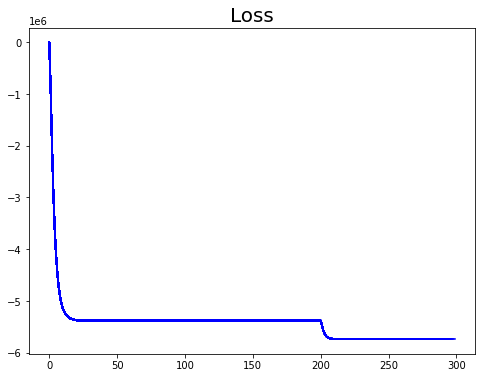

In [445]:
n_steps = 300
lr = np.append(np.linspace(0.6, 0.2, n_steps//3), np.linspace(0.15, 0.1, 2*n_steps//3))
losses = []
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_title('Loss', fontsize=20)
batch_size = 200
for step in range(n_steps):
    losses.append(loss(Y_curr, noisy_image))
    ax.plot(losses, c='b')
    
    grad = func_grad(Y_curr, noisy_image)
    Y_curr[1:m-1, 1:n-1] += lr[step] * grad
    Y_curr = np.sign(Y_curr)
    


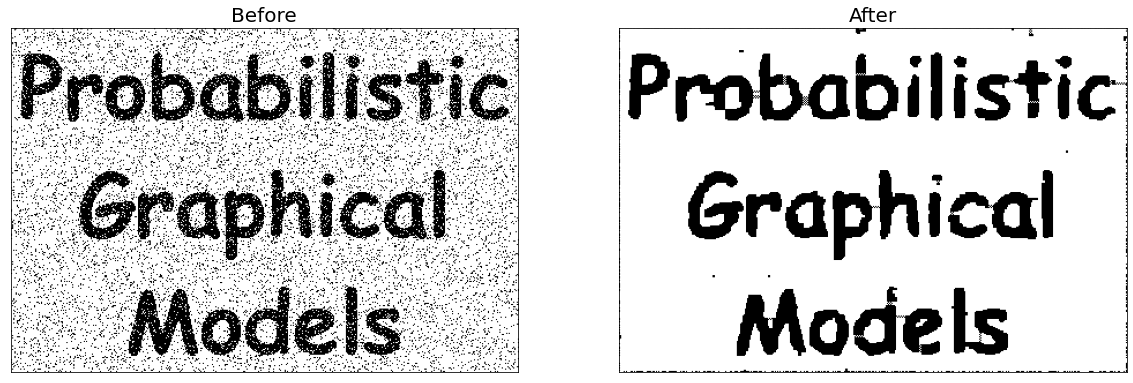

In [446]:
fig, axes = plt.subplots(ncols=2, nrows=1)

fig.set_figheight(10)
fig.set_figwidth(20)

axes[0].imshow(noisy_image, cmap='gray')
axes[0].set_title('Before', fontsize=20)
_ = axes[0].set_xticks([])
_ = axes[0].set_yticks([])

axes[1].imshow(Y_curr, cmap='gray')
axes[1].set_title('After', fontsize=20)
_ = axes[1].set_xticks([])
_ = axes[1].set_yticks([])
